# MLOps Modeling
## Credit Risk Classification — Analysis of the South German Credit Dataset




#Imports

In [ ]:
# =============================================================
# Instalar dependencias necesarias
# =============================================================
!pip install -q mlflow google-cloud-storage category_encoders imbalanced-learn xgboost

In [ ]:
# =============================================================
# Funciones futuras
# =============================================================
from __future__ import annotations

# =============================================================
# Librerías estándar de Python
# =============================================================
import os
import sys
import re
import json
import time
import warnings
import tempfile

# =============================================================
# Integración con Google Colab
# =============================================================
from google.colab import userdata, drive, auth

# =============================================================
# Librerías científicas principales
# =============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================
# Scikit-learn: base, preprocesamiento, pipelines, selección de modelos y métricas
# =============================================================
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_validate,
    cross_val_predict,
    GridSearchCV,
    ParameterGrid,  # 🔹 Added for custom grid iteration
)

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)

# =============================================================
# Imbalanced-learn: técnicas de balanceo y métricas
# =============================================================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.metrics import geometric_mean_score

# =============================================================
# Modelos de aprendizaje automático
# =============================================================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# =============================================================
# Codificadores y utilidades
# =============================================================
import category_encoders as ce

# =============================================================
# MLflow y Google Cloud Platform (GCP)
# =============================================================
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature
from google.cloud import storage

# =============================================================
# Configuración global
# =============================================================
RANDOM_STATE = 5
np.set_printoptions(suppress=True)
pd.set_option("display.max_colwidth", 120)
GMEAN_SCORER = make_scorer(geometric_mean_score)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# =============================================================
# 1) Autenticación y configuración inicial en Google Cloud + Drive
# =============================================================

# -------------------------------------------------------------
# 1.1) Autenticación manual en GCP (si el servicio MLflow lo requiere)
# -------------------------------------------------------------
# Este paso abre una ventana emergente para iniciar sesión con tu cuenta de Google.
!gcloud auth login

# -------------------------------------------------------------
# 1.2) Autenticación con Google Cloud desde Colab
# -------------------------------------------------------------
# Permite a Colab acceder a los servicios de Google Cloud (como Cloud Storage).
auth.authenticate_user()
print("✅ Autenticación con Google Cloud completada correctamente.")

# -------------------------------------------------------------
# 1.3) Montar Google Drive y acceder a la carpeta compartida
# -------------------------------------------------------------

drive.mount('/content/drive', force_remount=True)

FOLDER_ID = userdata.get('FOLDER_ID')
if not FOLDER_ID:
    raise ValueError("❌ FOLDER_ID not found. Define it in Colab > Variables de entorno.")

TARGET = f"/content/drive/.shortcut-targets-by-id/{FOLDER_ID}"
os.chdir(TARGET)


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  Y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.

#Configuracion Datos

In [ ]:
# =============================================================
# 1) Importar listas de columnas desde config.py
# =============================================================
sys.path.append(os.path.join(TARGET, "trabajo_grupal_mlops", "Notebooks"))
from config import num_col, ord_col, cat_col

In [ ]:
# =============================================================
# 2) Cargar parquet y preparar DataFrame
# =============================================================
parquet_path = os.path.join(TARGET, "trabajo_grupal_mlops", "data", "03_df_eda_01.parquet")
df = pd.read_parquet(parquet_path)

df = df.apply(pd.to_numeric).astype("int64")

# Invertir la clase objetivo (1->0 y 0->1)
if 'credit_risk' not in df.columns:
    raise KeyError("La columna 'credit_risk' no existe en el DataFrame.")
df['credit_risk'] = df['credit_risk'].apply(lambda x: 0 if x == 1 else 1)

print("Dataset shape:", df.shape)
print(df['credit_risk'].value_counts())

Dataset shape: (992, 21)
credit_risk
0    689
1    303
Name: count, dtype: int64


In [ ]:
# =============================================================
# 3) Split de datos
# =============================================================
X = df.drop(columns=['credit_risk'])
y = df['credit_risk']
RANDOM_STATE = 5

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print("Dimensiones:")
print("  Entrenamiento:", Xtrain.shape, ytrain.shape)
print("  Prueba:", Xtest.shape, ytest.shape)

tmp_pos = (ytrain.sum() / ytrain.shape[0])
print(f"Distribución clases (train) -> Positiva: {tmp_pos*100:.2f}%, Negativa: {(1-tmp_pos)*100:.2f}%")

Dimensiones:
  Entrenamiento: (694, 20) (694,)
  Prueba: (298, 20) (298,)
Distribución clases (train) -> Positiva: 30.55%, Negativa: 69.45%


In [ ]:
# =============================================================
# 4) Wrapper para BinaryEncoder (compatible con ColumnTransformer)
# =============================================================
class BinaryEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = ce.BinaryEncoder(cols=self.cols)
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.cols)
        self.encoder.fit(X_df)
        try:
            self.feature_names_out_ = self.encoder.get_feature_names_out()
        except AttributeError:
            self.feature_names_out_ = list(self.encoder.transform(X_df).columns)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.cols)
        return self.encoder.transform(X_df).to_numpy()

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [ ]:
# =============================================================
# 5) Pipelines por tipo de variable
# =============================================================
numericas_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
])

nominales_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', BinaryEncoderWrapper(cols=cat_col)),
])

ordinales_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

In [ ]:
# =============================================================
# 6) ColumnTransformer unificado
# =============================================================
columnasTransformer = ColumnTransformer(
    transformers=[
        ('num', numericas_pipe, num_col),
        ('nom', nominales_pipe, cat_col),
        ('ord', ordinales_pipe, ord_col),
    ],
    verbose_feature_names_out=False,
    remainder='drop'
)

pre = columnasTransformer  # alias

In [ ]:
# =============================================================
# 7) Verificación de dimensión tras preprocesamiento
# =============================================================
Xtmp = Xtrain.copy()
Xt = pre.fit_transform(Xtmp)
print("Dimensión entradas antes:", Xtmp.shape, " | después:", Xt.shape)

Dimensión entradas antes: (694, 20)  | después: (694, 37)


In [ ]:
# =============================================================
# 8) Unificar conjuntos de entrenamiento y prueba para análisis global
# =============================================================
Xtraintest = pd.concat([Xtrain, Xtest], axis=0)
ytraintest = pd.concat([ytrain, ytest], axis=0)

#Configuracion para Modelado

In [ ]:
# =============================================================
# 1) Train, cross-validate, and visualize model performance
# =============================================================
def mi_fun(modelo, nombre, Xtraintest, ytraintest, metodo_uo=None):
    """
    Trains and evaluates a model using cross-validation (CV),
    computes multiple performance metrics, and displays the
    Out-Of-Fold (OOF) confusion matrix.

    Parameters:
    -----------
    modelo : estimator
        The base model (e.g., LogisticRegression, RandomForestClassifier).
    nombre : str
        Name of the model for display and output purposes.
    Xtraintest : DataFrame
        Features dataset for training and testing.
    ytraintest : Series or array
        Target variable.
    metodo_uo : object or None
        Sampling method (e.g., SMOTE, NearMiss) or None if not used.

    Returns:
    --------
    DataFrame
        Summary table with average training/testing metrics across folds.
    """

    # -------------------------------------------------------------
    # 1.1) Build pipeline with preprocessing, optional sampler, and model
    # -------------------------------------------------------------
    pipeline = ImbPipeline(steps=[
        ('pre', pre),
        ('sampler', metodo_uo),
        ('model', modelo)
    ])

    # -------------------------------------------------------------
    # 1.2) Define cross-validation and metrics
    # -------------------------------------------------------------
    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
    mismetricas = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'F1': 'f1',
        'AUC': 'roc_auc',
        'Gmean': GMEAN_SCORER
    }

    # -------------------------------------------------------------
    # 1.3) Perform cross-validation and collect scores
    # -------------------------------------------------------------
    scores = cross_validate(
        pipeline,
        Xtraintest,
        np.ravel(ytraintest),
        scoring=mismetricas,
        cv=micv,
        return_train_score=True
    )

    # -------------------------------------------------------------
    # 1.4) Aggregate and display results (train/test mean ± std)
    # -------------------------------------------------------------
    rows = []
    for metric in mismetricas.keys():
        test_mean  = np.nanmean(scores[f'test_{metric}'])
        test_std   = np.nanstd(scores[f'test_{metric}'])
        train_mean = np.nanmean(scores[f'train_{metric}'])
        train_std  = np.nanstd(scores[f'train_{metric}'])
        rows.append({
            "MODEL": nombre,
            "TEST NAME": metric,
            "TRAIN": f"{train_mean:.4f} (±{train_std:.3f})",
            "TEST":  f"{test_mean:.4f} (±{test_std:.3f})"
        })

    df_results = pd.DataFrame(rows)
    print(f"\n>> Results for {nombre}")
    print(df_results.to_string(index=False))

    # -------------------------------------------------------------
    # 1.5) Compute Out-Of-Fold (OOF) confusion matrix
    # -------------------------------------------------------------
    cv_cm = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    y_true = np.ravel(ytraintest)
    y_pred_oof = cross_val_predict(pipeline, Xtraintest, y_true, cv=cv_cm, method='predict')

    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred_oof, labels=labels)

    # -------------------------------------------------------------
    # 1.6) Plot OOF confusion matrix
    # -------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(3, 3))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(
        ax=ax, cmap="cividis", values_format="d", colorbar=False
    )
    ax.set_title(f"Confusion Matrix — {nombre}")
    plt.show()

    # -------------------------------------------------------------
    # 1.7) Return summary DataFrame
    # -------------------------------------------------------------
    return df_results

In [ ]:
# =============================================================
# 1) Builders
# =============================================================
def build_pipeline(model, preprocessor, sampler=None):
    """
    Create an imbalanced-learn Pipeline: preprocessor -> (sampler?) -> model
    """
    steps = [('pre', preprocessor)]
    if sampler is not None:
        steps.append(('sampler', sampler))
    steps.append(('model', model))
    return ImbPipeline(steps=steps)

def build_search_pipeline(model, sampler=None):
    """
    Convenience wrapper that injects global 'pre' as the preprocessor.
    """
    return build_pipeline(model=model, preprocessor=pre, sampler=sampler)

In [ ]:
# =============================================================
# 2) GridSearchCV + MLflow logging (with signature & input_example)
# =============================================================

GRID_RESULTS = {}  # in-memory registry of last GridSearch objects/results

def _name_of(obj):
    """Robust class-name retrieval for MLflow tags/params."""
    try:
        return obj.__class__.__name__
    except Exception:
        return str(obj)

def _infer_signature_safe(pipeline, X_example):
    """
    Try predict_proba for signature; fallback to predict if not available.
    Returns (signature, y_example).
    """
    try:
        y_example = pipeline.predict_proba(X_example)[:, 1]
    except Exception:
        y_example = pipeline.predict(X_example)
    signature = infer_signature(X_example, y_example)
    return signature, y_example

def run_grid_search(
    name: str,
    model,
    param_grid: dict,
    sampler=None,
    cv_splits: int = 5,
    random_state: int = 42,
    verbose: int = 1,
    register_name: str | None = None,
    log_child_candidates: bool = True,
    log_child_models: bool = False,
    # ---- Gating thresholds ----
    min_test_auc: float = 0.70,
    max_gap_auc: float = 0.05,
    min_test_f1: float = 0.50,
    max_gap_f1: float = 0.06,
    child_register_best: bool = True
):
    """
    GridSearchCV (refit='roc_auc') with MLflow logging:
      • Parent run: config + best summary metrics (no gate tags)
      • Child runs: CV train/test metrics, gate tags & diagnostics
      • Best passing child: logs & optionally registers model
    """
    # ---------------------------------------------------------
    # 1) Build pipeline & CV/scoring setup
    # ---------------------------------------------------------
    pipe = build_search_pipeline(model, sampler=sampler)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    scoring = {
        "roc_auc": "roc_auc",
        "f1": make_scorer(f1_score, zero_division=0, pos_label=1),
        "precision": make_scorer(precision_score, zero_division=0, pos_label=1),
        "recall": make_scorer(recall_score, zero_division=0, pos_label=1),
        "accuracy": make_scorer(accuracy_score),
    }

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True
    )

    X_example = Xtraintest.head(5).copy()

    # ---------------------------------------------------------
    # 2) Parent MLflow run (no gate tags)
    # ---------------------------------------------------------
    with mlflow.start_run(run_name=f"{name}__GRID"):
        mlflow.set_tags({
            "stage": "grid-search",
            "pipeline": "pre->(sampler?)->model",
            "model_cls": _name_of(model),
            "sampler": _name_of(sampler) if sampler is not None else "None",
            "cv_splits": cv_splits,
            "random_state": random_state
        })
        for k, v in param_grid.items():
            mlflow.log_param(f"grid_{k}", json.dumps(v, ensure_ascii=False))

        # -----------------------------------------------------
        # 3) Live progress per candidate
        # -----------------------------------------------------
        param_list = list(ParameterGrid(param_grid))
        n_total = len(param_list)
        print(f"\n🔄 Starting GridSearchCV for '{name}' — {n_total} total candidates...\n")

        start_time = time.time()
        orig_run_search = gs._run_search

        def custom_run_search(self, evaluate_candidates):
            for i, params in enumerate(param_list, 1):
                print(f"→ [{i}/{n_total}] Fitting: {params}")
                sys.stdout.flush()
                evaluate_candidates([params])
                elapsed = time.time() - start_time
                print(f"   ✅ Finished candidate {i}/{n_total} ({elapsed:.1f}s elapsed)\n")
                sys.stdout.flush()

        gs._run_search = custom_run_search.__get__(gs, type(gs))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gs.fit(Xtraintest, np.ravel(ytraintest))

        gs._run_search = orig_run_search
        print("\n✅ GridSearchCV complete.\n")

        # -----------------------------------------------------
        # 4) Parent summary (no gating)
        # -----------------------------------------------------
        best_pipe   = gs.best_estimator_
        best_score  = float(gs.best_score_)
        best_params = dict(gs.best_params_)
        best_idx    = int(gs.best_index_)

        mlflow.log_metric("cv_best_test_roc_auc", best_score)
        mlflow.log_params({f"best::{k}": v for k, v in best_params.items()})

        cvdf = pd.DataFrame(gs.cv_results_)
        metric_cols_test  = [c for c in cvdf.columns if c.startswith("mean_test_")]
        metric_cols_train = [c for c in cvdf.columns if c.startswith("mean_train_")]

        # Log CV means of best candidate
        for col in metric_cols_test:
            mlflow.log_metric(
                col.replace("mean_test_", "cv_best_test_"),
                float(cvdf.loc[best_idx, col])
            )
        for col in metric_cols_train:
            mlflow.log_metric(
                col.replace("mean_train_", "cv_best_train_"),
                float(cvdf.loc[best_idx, col])
            )

        # Save CV table
        with tempfile.TemporaryDirectory() as tmpd:
            csv_path = os.path.join(tmpd, f"{name.replace(' ', '_')}_cv_results.csv")
            cvdf.to_csv(csv_path, index=False)
            mlflow.log_artifact(csv_path, artifact_path="cv_results")

        # -----------------------------------------------------
        # 5) CHILD runs with gate logic + model logging
        # -----------------------------------------------------
        if log_child_candidates:
            for i in range(len(cvdf)):
                cand_params = cvdf.loc[i, "params"]
                is_best = (i == best_idx)

                # Extract CV metrics
                cand_train_auc = float(cvdf.loc[i, "mean_train_roc_auc"])
                cand_test_auc  = float(cvdf.loc[i, "mean_test_roc_auc"])
                cand_train_f1  = float(cvdf.loc[i, "mean_train_f1"])
                cand_test_f1   = float(cvdf.loc[i, "mean_test_f1"])

                cand_gap_auc = abs(cand_train_auc - cand_test_auc)
                cand_gap_f1  = abs(cand_train_f1  - cand_test_f1)

                cand_underfit = (
                    (cand_test_auc < min_test_auc and cand_train_auc < min_test_auc) or
                    (cand_test_f1  < min_test_f1  and cand_train_f1  < min_test_f1)
                )
                cand_overfit  = (cand_gap_auc > max_gap_auc) or (cand_gap_f1 > max_gap_f1)
                cand_passes_gate = (
                    (not cand_underfit) and (not cand_overfit) and
                    (cand_test_auc >= min_test_auc) and (cand_test_f1 >= min_test_f1)
                )

                with mlflow.start_run(run_name=f"{name}__cand_{i}", nested=True):
                    # Params and tags
                    mlflow.log_params({f"cand::{k}": v for k, v in cand_params.items()})
                    mlflow.set_tags({
                        "candidate_index": str(i),
                        "is_best": str(is_best),
                        "model_cls": _name_of(model),
                        "sampler": _name_of(sampler) if sampler is not None else "None",
                        "gate_underfit": str(cand_underfit),
                        "gate_overfit":  str(cand_overfit),
                        "gate_passes":   str(cand_passes_gate),
                        "gate_rules":    f"min_test_auc>={min_test_auc}; max_gap_auc<={max_gap_auc}; "
                                         f"min_test_f1>={min_test_f1}; max_gap_f1<={max_gap_f1}"
                    })

                    # Log metrics for this candidate
                    for col in metric_cols_test:
                        mlflow.log_metric(
                            col.replace("mean_test_", "cv_cand_test_"),
                            float(cvdf.loc[i, col])
                        )
                    for col in metric_cols_train:
                        mlflow.log_metric(
                            col.replace("mean_train_", "cv_cand_train_"),
                            float(cvdf.loc[i, col])
                        )

                    mlflow.log_metrics({
                        "gate_gap_auc": cand_gap_auc,
                        "gate_gap_f1":  cand_gap_f1
                    })

                    # (A) Save candidate model if log_child_models=True and gate passes
                    if log_child_models and cand_passes_gate:
                        cand_pipe = clone(pipe).set_params(**cand_params)
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            cand_pipe.fit(Xtraintest, np.ravel(ytraintest))
                        signature, _ = _infer_signature_safe(cand_pipe, X_example)
                        mlflow.sklearn.log_model(
                            sk_model=cand_pipe,
                            name=f"cand_model_{i}",
                            registered_model_name=None,
                            input_example=X_example,
                            signature=signature
                        )
                        mlflow.set_tags({"gate_action": "child_logged"})
                    else:
                        reason = "overfit" if cand_overfit else ("underfit" if cand_underfit else "failed_thresholds")
                        mlflow.set_tags({"gate_action": f"child_REJECTED_{reason}"})

                    # (B) Log + optionally register ONLY the best passing child
                    if is_best and cand_passes_gate and child_register_best:
                        best_child_pipe = clone(pipe).set_params(**cand_params)
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            best_child_pipe.fit(Xtraintest, np.ravel(ytraintest))
                        signature, _ = _infer_signature_safe(best_child_pipe, X_example)
                        mlflow.sklearn.log_model(
                            sk_model=best_child_pipe,
                            name="best_model",
                            #registered_model_name=register_name,
                            input_example=X_example,
                            signature=signature
                        )
                        mlflow.set_tags({"gate_action": "best_child_logged_and_registered"})

        # Parent remains clean of gate tags

    # ---------------------------------------------------------
    # 6) Cache results + summary
    # ---------------------------------------------------------
    GRID_RESULTS[name] = {
        "gs": gs,
        "best_pipe": gs.best_estimator_,
        "best_score": float(gs.best_score_),
        "best_params": dict(gs.best_params_)
    }

    print(f"\n[{name}] Best CV AUC (validation/test folds): {float(gs.best_score_):.4f}")
    print(f"[{name}] Best params: {dict(gs.best_params_)}")
    return gs.best_estimator_, float(gs.best_score_), dict(gs.best_params_)

#Configuracion para MLFlow

In [ ]:
# =============================================================
# 1) Configurar MLflow: Tracking URI y Experimento
# =============================================================

MLFLOW_SERVER_URI_WITH_POSTGRE_SQL = "https://mlflow-super-g57-137680020436.us-central1.run.app"
EXPERIMENT_ID = "Experimento-Conexión-MLFlow-Grupo57"

mlflow.set_tracking_uri(MLFLOW_SERVER_URI_WITH_POSTGRE_SQL)
mlflow.set_experiment(EXPERIMENT_ID)
print("🔗 MLflow tracking URI configurado y experimento seleccionado correctamente.")

🔗 MLflow tracking URI configurado y experimento seleccionado correctamente.


#Modelado


🔄 Starting GridSearchCV for 'LogReg + SMOTE v2' — 8 total candidates...

→ [1/8] Fitting: {'model__C': 0.05, 'model__class_weight': None, 'model__penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 1/8 (13.2s elapsed)

→ [2/8] Fitting: {'model__C': 0.05, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2/8 (15.9s elapsed)

→ [3/8] Fitting: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 3/8 (18.8s elapsed)

→ [4/8] Fitting: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 4/8 (21.8s elapsed)

→ [5/8] Fitting: {'model__C': 0.5, 'model__class_weight': None, 'model__penalty': 'l2'}
Fitting 5 folds for each of 1 candidates, totalling 5 fi

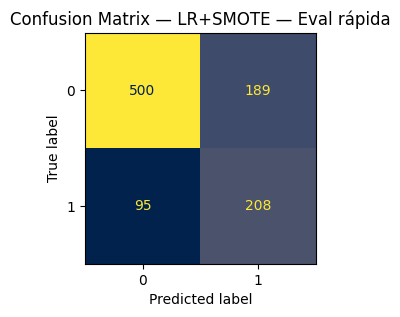

In [ ]:
name = "LogReg + SMOTE v2"
model = LogisticRegression(solver="saga", max_iter=3000, random_state=RANDOM_STATE)
sampler = SMOTE(random_state=RANDOM_STATE)

param_grid = {
    "model__C": [0.05, 0.1, 0.5, 1.0],
    "model__penalty": ["l2"],
    "model__class_weight": [None, "balanced"]
}

best_pipe_lr, best_auc_lr, best_params_lr = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name= "g57-LR",
    log_child_candidates=True,
    log_child_models=True,
    verbose=2
)

#_ = mi_fun(model, "LR+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)

In [ ]:
name = "KNN + SMOTE v2"
model = KNeighborsClassifier()

sampler = SMOTE(random_state=RANDOM_STATE)

param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],
    "model__leaf_size": [15, 30, 45]
}

best_pipe_knn, best_auc_knn, best_params_knn = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name="g57-knn",
    log_child_candidates=True,
    log_child_models=True
)

#_ = mi_fun(model, "KNN+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)


🔄 Starting GridSearchCV for 'KNN + SMOTE v2' — 60 total candidates...

→ [1/60] Fitting: {'model__leaf_size': 15, 'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'uniform'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 1/60 (1.6s elapsed)

→ [2/60] Fitting: {'model__leaf_size': 15, 'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'distance'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2/60 (3.6s elapsed)

→ [3/60] Fitting: {'model__leaf_size': 15, 'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'uniform'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 3/60 (6.9s elapsed)

→ [4/60] Fitting: {'model__leaf_size': 15, 'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 4/60 (8.7s elapsed)

→ [5/60] Fitting: {'model__leaf_size': 15, 'model__n_neighbors

In [ ]:
name = "SVC + SMOTE v2"
model = SVC(
    kernel="rbf",
    probability=True,
    random_state=RANDOM_STATE
)

sampler = SMOTE(random_state=RANDOM_STATE)

param_grid = {
    "model__kernel": ["rbf", "linear"],
    "model__C": [0.1, 1, 5, 10],
    "model__gamma": ["scale", "auto", 0.01, 0.1],
    "model__class_weight": [None, "balanced"]
}

best_pipe_svc, best_auc_svc, best_params_svc = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name="g57-svc",
    log_child_candidates=True,
    log_child_models=True
)

#_ = mi_fun(model, "SVC+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)


🔄 Starting GridSearchCV for 'SVC + SMOTE v2' — 64 total candidates...

→ [1/64] Fitting: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 1/64 (3.4s elapsed)

→ [2/64] Fitting: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2/64 (5.7s elapsed)

→ [3/64] Fitting: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 3/64 (9.7s elapsed)

→ [4/64] Fitting: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'auto', 'model__kernel': 'linear'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 4/64 (13.5s elapsed)

→ [5/64] Fitting: {'model__C': 0.1, 'model__class_w

In [ ]:
name = "MLP + SMOTE v2"
model = MLPClassifier(
    max_iter=500,
    early_stopping=True,
    random_state=RANDOM_STATE
)

sampler = SMOTE(random_state=RANDOM_STATE)

param_grid = {
    "model__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "model__activation": ["relu", "tanh"],
    "model__alpha": [1e-4, 1e-3, 1e-2],
    "model__learning_rate_init": [0.001, 0.01],
    "model__batch_size": [32, 64, 128]

}

best_pipe_mlp, best_auc_mlp, best_params_mlp = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name="g57-mlp",
    log_child_candidates=True,
    log_child_models=True
)

#_ = mi_fun(model, "MLP+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)


🔄 Starting GridSearchCV for 'MLP + SMOTE v2' — 144 total candidates...

→ [1/144] Fitting: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__batch_size': 32, 'model__hidden_layer_sizes': (64,), 'model__learning_rate_init': 0.001}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 1/144 (8.1s elapsed)

→ [2/144] Fitting: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__batch_size': 32, 'model__hidden_layer_sizes': (64,), 'model__learning_rate_init': 0.01}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2/144 (11.5s elapsed)

→ [3/144] Fitting: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__batch_size': 32, 'model__hidden_layer_sizes': (128,), 'model__learning_rate_init': 0.001}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 3/144 (16.6s elapsed)

→ [4/144] Fitting: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__batch_size': 32, 'm

In [ ]:
name = "DecisionTree + SMOTE v2"
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

sampler = SMOTE(random_state=RANDOM_STATE)

param_grid = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [None, "sqrt", "log2"],
    "model__class_weight": [None, "balanced"]
}

best_pipe_dt, best_auc_dt, best_params_dt = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name="g57-dt",
    log_child_candidates=True,
    log_child_models=True
)

#_ = mi_fun(model, "DT+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)


🔄 Starting GridSearchCV for 'DecisionTree + SMOTE v2' — 810 total candidates...

→ [1/810] Fitting: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 1/810 (1.2s elapsed)

→ [2/810] Fitting: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2/810 (2.8s elapsed)

→ [3/810] Fitting: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 3/810 (4.9s elapsed)

→ [4/810] Fitting: {'mo

In [ ]:
name = "RandomForest + SMOTE v2"
model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

sampler = SMOTE(random_state=RANDOM_STATE)

param_grid = {
    "model__n_estimators": [200, 400, 800],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__class_weight": [None, "balanced"]
}

best_pipe_rf, best_auc_rf, best_params_rf = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name="g57-rf",
    log_child_candidates=True,
    log_child_models=True
)

#_ = mi_fun(model, "RF+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)


🔄 Starting GridSearchCV for 'RandomForest + SMOTE v2' — 648 total candidates...

→ [1/648] Fitting: {'model__class_weight': None, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 1/648 (11.0s elapsed)

→ [2/648] Fitting: {'model__class_weight': None, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2/648 (19.5s elapsed)

→ [3/648] Fitting: {'model__class_weight': None, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 800}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 3/648 (39.2s elapsed)

→ [4/648] Fitti

In [ ]:
name = "XGBoost + SMOTE v2"
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbosity=0
)

sampler = SMOTE(random_state=RANDOM_STATE)

pos = float(ytraintest.sum())
neg = float(len(ytraintest) - pos)
SCALE_POS_WEIGHT = neg / max(pos, 1.0)

param_grid = {
    "model__n_estimators": [200, 400, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_lambda": [1.0, 3.0, 5.0],
    "model__scale_pos_weight": [1.0, SCALE_POS_WEIGHT, SCALE_POS_WEIGHT * 1.5]
}

best_pipe_xgb, best_auc_xgb, best_params_xgb = run_grid_search(
    name=name,
    model=model,
    param_grid=param_grid,
    sampler=sampler,
    register_name="g57-xgb",
    log_child_candidates=True,
    log_child_models=True
)

#_ = mi_fun(model, "XGB+SMOTE — Eval rápida", Xtraintest, ytraintest, metodo_uo=sampler)

Streaming output truncated to the last 5000 lines.
   ✅ Finished candidate 2033/2187 (10419.6s elapsed)

→ [2034/2187] Fitting: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__reg_lambda': 1.0, 'model__scale_pos_weight': 3.410891089108911, 'model__subsample': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2034/2187 (10422.4s elapsed)

→ [2035/2187] Fitting: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__reg_lambda': 3.0, 'model__scale_pos_weight': 1.0, 'model__subsample': 0.7}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   ✅ Finished candidate 2035/2187 (10426.7s elapsed)

→ [2036/2187] Fitting: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__reg_lambda': 3.0, 'model__scale_pos_weight': 1.0, 'model__subsample': 0.9